<a href="https://colab.research.google.com/github/zakirangwala/esrb-wizard/blob/main/notebooks/model_demo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Do Players Enjoy Games with Content Warnings More?**

#1. Data Proprocessing

In [2]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sklearn

### Steam Data

In [218]:
# loading the dataset (originally from https://www.kaggle.com/datasets/fronkongames/steam-games-dataset; had to manually add a comma to separate Discount and DLC)
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/CP322/games.csv" # save to github: notebooks/model_demo_colab.ipynb
steam = pd.read_csv(path, index_col=False)
steam.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,Discount,DLC count,About the game,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [237]:
# First check that all AppID columns are unique in order to ensure no games listed twice
steam = steam.dropna(subset=['AppID', 'Name'])
print("Dataset Dimensions: ", steam.shape)
print("Unique columns in 'AppID': ", steam['AppID'].nunique())
print("Unique columns in 'Name': ", steam['Name'].nunique())

Dataset Dimensions:  (111446, 40)
Unique columns in 'AppID':  111446
Unique columns in 'Name':  110325


We first drop missing rows since they're both unique identifiers and it's not possible to impute those values. Since the shape and the number of unique rows in AppID are exact, we know that we are not double counting a game. But we notice that there are repeat values in name - this is because some games become region-locked and are only avaiable to play in certain countries. In some cases, there are multiple versions that exist so that. Should we cut these?

In [238]:
# Dropping uneccessary columns
steam_drop= steam.drop(['AppID', 'Discount', 'About the game', 'Reviews',
                        'Header image', 'Required age', 'Tags',
                        'Website', 'Support url', 'Support email',
                        'Metacritic url', 'Score rank', 'Notes',
                        'Developers', 'Screenshots', 'Movies',
                        'Average playtime forever', 'Median playtime forever'
                        ], axis=1)
steam_drop.head()

,Name,Release date,Estimated owners,Peak CCU,Price,DLC count,Supported languages,Full audio languages,Windows,Mac,...,User score,Positive,Negative,Achievements,Recommendations,Average playtime two weeks,Median playtime two weeks,Publishers,Categories,Genres
0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,19.99,0,['English'],[],True,False,...,0,6,11,30,0,0,0,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports"
1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,...,0,53,5,12,0,0,0,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie"
2,Jolt Project,"Nov 17, 2021",0 - 20000,0,4.99,0,"['English', 'Portuguese - Brazil']",[],True,False,...,0,0,0,0,0,0,0,Campião Games,Single-player,"Action,Adventure,Indie,Strategy"
3,Henosis™,"Jul 23, 2020",0 - 20000,0,5.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,...,0,3,0,0,0,0,0,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie"
4,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0.00,0,"['English', 'Spanish - Spain']",[],True,True,...,0,50,8,17,0,0,0,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie"


dropping those columns (either it's a unique identifier that we don't need, heavy text based, images of the game, contact information, or ambiguous meaning, or info players would not have access to without Google. Or in the case of discount doesn't impact how a player will play just if they will purchase a game)

In [239]:
steam_drop['release_year'] = steam_drop['Release date'].str.split(',').str[1]
steam_drop = steam_drop.drop(['Release date'], axis=1).astype('category')
steam_drop.head()

,Name,Estimated owners,Peak CCU,Price,DLC count,Supported languages,Full audio languages,Windows,Mac,Linux,...,Positive,Negative,Achievements,Recommendations,Average playtime two weeks,Median playtime two weeks,Publishers,Categories,Genres,release_year
0,Galactic Bowling,0 - 20000,0,19.99,0,['English'],[],True,False,False,...,6,11,30,0,0,0,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports",2008
1,Train Bandit,0 - 20000,0,0.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,False,...,53,5,12,0,0,0,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie",2017
2,Jolt Project,0 - 20000,0,4.99,0,"['English', 'Portuguese - Brazil']",[],True,False,False,...,0,0,0,0,0,0,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",2021
3,Henosis™,0 - 20000,0,5.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,True,True,...,3,0,0,0,0,0,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie",2020
4,Two Weeks in Painland,0 - 20000,0,0.00,0,"['English', 'Spanish - Spain']",[],True,True,False,...,50,8,17,0,0,0,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie",2020


XGBoost and Random Forests cannot work with the date directly. Instead, we take the release year (what is usually mentioned when games are discussed. Months and days are rarely relevant)

In [240]:
print("Unique columns in 'Estimated owners': ", steam_drop['Estimated owners'].nunique())
#print(steam_drop['Estimated owners'].unique())

owners_mapping = {
    '0 - 0': 0,
    '0 - 20000': 10000,
    '20000 - 50000': 35000,
    '50000 - 100000': 75000,
    '100000 - 200000': 150000,
    '200000 - 500000': 350000,
    '500000 - 1000000': 750000,
    '1000000 - 2000000': 1500000,
    '2000000 - 5000000': 3500000,
    '5000000 - 10000000': 7500000,
    '10000000 - 20000000': 15000000,
    '20000000 - 50000000': 35000000,
    '50000000 - 100000000': 75000000,
    '100000000 - 200000000': 150000000
}

steam_drop['midpoint_estimated_owners'] = steam_drop['Estimated owners'].map(owners_mapping)
steam_drop= steam_drop.drop(['Estimated owners'], axis=1) # we have a better column now

print("Unique columns in 'midpoint_estimated_owners': ", steam_drop['midpoint_estimated_owners'].nunique())
#print(steam_drop['midpoint_estimated_owners'].unique())
print("Dataframe size after taking midpoint of estimated owner size range", steam_drop.shape)

Unique columns in 'Estimated owners':  14
Unique columns in 'midpoint_estimated_owners':  14
Dataframe size after taking midpoint of estimated owner size range (111446, 22)


Using a midpoint for the estimated number of ownsers gives a much better representation for what the sales look like compared to have categorical values.

In [241]:
print("Dataframe size before dropping non-english games", steam_drop.shape)

steam_drop = steam_drop[steam_drop['Supported languages'].apply(lambda x: 'English' in x)]
steam_drop = steam_drop.drop(['Supported languages'], axis=1) # no longer need it if all games are english

print("Dataframe size after dropping non-english games", steam_drop.shape)

steam_drop = steam_drop[steam_drop['Full audio languages'].apply(lambda x: (len(x) == 2 or 'English' in x))]
# if we make this 0, we could have 40000 rows of only english voice acting games

steam_drop['voice_acting'] = steam_drop['Full audio languages'].apply(lambda x: 0 if len(x) == 2 else 1).astype('category')
# 0 means no, 1 means yes it has voice acting
steam_drop = steam_drop.drop(['Full audio languages'], axis=1)

print("Dataframe size after dropping games that have audio exclusively in another language", steam_drop.shape)
steam_drop.tail()

Dataframe size before dropping non-english games (111446, 22)
Dataframe size after dropping non-english games (99911, 21)
Dataframe size after dropping games that have audio exclusively in another language (97272, 21)


,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Positive,...,Achievements,Recommendations,Average playtime two weeks,Median playtime two weeks,Publishers,Categories,Genres,release_year,midpoint_estimated_owners,voice_acting
111447,Paragon Of Time,0,2.99,0,True,False,False,0,0,5,...,0,0,0,0,Webcess,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie",2025,10000,0
111448,A Few Days With : Hazel,0,2.69,0,True,False,False,0,0,0,...,7,0,0,0,Hentai Panda,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie",2025,10000,0
111449,MosGhost,0,7.99,0,True,False,False,0,0,24,...,0,0,0,0,"Sinka Games,Arkuda Inc.","Single-player,Family Sharing",Simulation,2025,10000,0
111450,AccuBow VR,0,0.00,0,True,False,False,0,0,0,...,0,0,0,0,AccuBow LLC,"Single-player,Tracked Controller Support,VR On...","Action,Adventure,Free To Play",2025,0,1
111451,Defense Of Fort Burton,0,9.99,0,True,False,False,0,0,0,...,5,0,0,0,Ledx,"Single-player,Steam Achievements,Steam Cloud,S...","Action,Casual,Strategy,Early Access",2025,10000,1


Being a North American independent rating company, ESRB usually only rates English games. Thus, we are interested in looking at games that support both English text and only games that either have English voice acting or no voice acting (audio we transform into a categorical value on if it contains voice acting or not).

In [242]:
boolean_mapping = {
    True: 1,
    False: 0
}

steam_drop['Windows'] = steam_drop['Windows'].map(boolean_mapping).astype('category')
steam_drop['Mac'] = steam_drop['Mac'].map(boolean_mapping).astype('category')
steam_drop['Linux'] = steam_drop['Linux'].map(boolean_mapping).astype('category')

steam_drop.head()

,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Positive,...,Achievements,Recommendations,Average playtime two weeks,Median playtime two weeks,Publishers,Categories,Genres,release_year,midpoint_estimated_owners,voice_acting
0,Galactic Bowling,0,19.99,0,1,0,0,0,0,6,...,30,0,0,0,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports",2008,10000,0
1,Train Bandit,0,0.99,0,1,1,0,0,0,53,...,12,0,0,0,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie",2017,10000,0
2,Jolt Project,0,4.99,0,1,0,0,0,0,0,...,0,0,0,0,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",2021,10000,0
3,Henosis™,0,5.99,0,1,1,1,0,0,3,...,0,0,0,0,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie",2020,10000,0
4,Two Weeks in Painland,0,0.00,0,1,1,0,0,0,50,...,17,0,0,0,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie",2020,10000,0


In [244]:
# Attempting to show the relationship between how many reviews are positive vs negative in a game
steam_drop['Positive'] = steam_drop['Positive'].astype(int)
steam_drop['Negative'] = steam_drop['Negative'].astype(int)
steam_drop['%_positive_reviews'] = (steam_drop['Positive'])/(steam_drop['Positive']+ steam_drop['Negative']) * 100
steam_drop.head()

,Name,Peak CCU,Price,DLC count,Windows,Mac,Linux,Metacritic score,User score,Positive,...,Recommendations,Average playtime two weeks,Median playtime two weeks,Publishers,Categories,Genres,release_year,midpoint_estimated_owners,voice_acting,%_positive_reviews
0,Galactic Bowling,0,19.99,0,1,0,0,0,0,6,...,0,0,0,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports",2008,10000,0,35.294118
1,Train Bandit,0,0.99,0,1,1,0,0,0,53,...,0,0,0,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie",2017,10000,0,91.379310
2,Jolt Project,0,4.99,0,1,0,0,0,0,0,...,0,0,0,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",2021,10000,0,NaN
3,Henosis™,0,5.99,0,1,1,1,0,0,3,...,0,0,0,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie",2020,10000,0,100.000000
4,Two Weeks in Painland,0,0.00,0,1,1,0,0,0,50,...,0,0,0,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie",2020,10000,0,86.206897


In [245]:
# Working to transform categorical list columns via multilabel encoding
import ast
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Working with the Genres
genres = steam_drop[['Name','Genres']].copy()
genres['Genres'] = genres['Genres'].fillna('').apply(lambda x: [g.strip() for g in x.split(',')] if x else [])

genres_encoded = pd.DataFrame(mlb.fit_transform(genres['Genres']),columns=mlb.classes_, index=genres.index)
genres = pd.concat([genres[['Name']], genres_encoded], axis=1)

# Working with the Categories
categories = steam_drop[['Name','Categories']].copy()
categories['Categories'] = categories['Categories'].fillna('').apply(lambda x: [g.strip() for g in x.split(',')] if x else [])

categories_encoded = pd.DataFrame(mlb.fit_transform(categories['Categories']),columns=mlb.classes_, index=categories.index)
categories = pd.concat([categories[['Name']], categories_encoded], axis=1)

# Merging new datasets back into the Steam dataset
steam_encoded = pd.merge(steam_drop, genres, on='Name', how='inner')
steam_encoded = pd.merge(steam_encoded, categories, on='Name', how='inner')
steam_encoded.head()


TypeError: Cannot setitem on a Categorical with a new category (), set the categories first

Well we wanted to create encoding to see if any of the genres or categories play an important role. But they were original strings. We had to first convert to arrays by splitting on the comma, and then transforming each unique value into a column. There's so many here... maybe we drop the ones that don't make sense

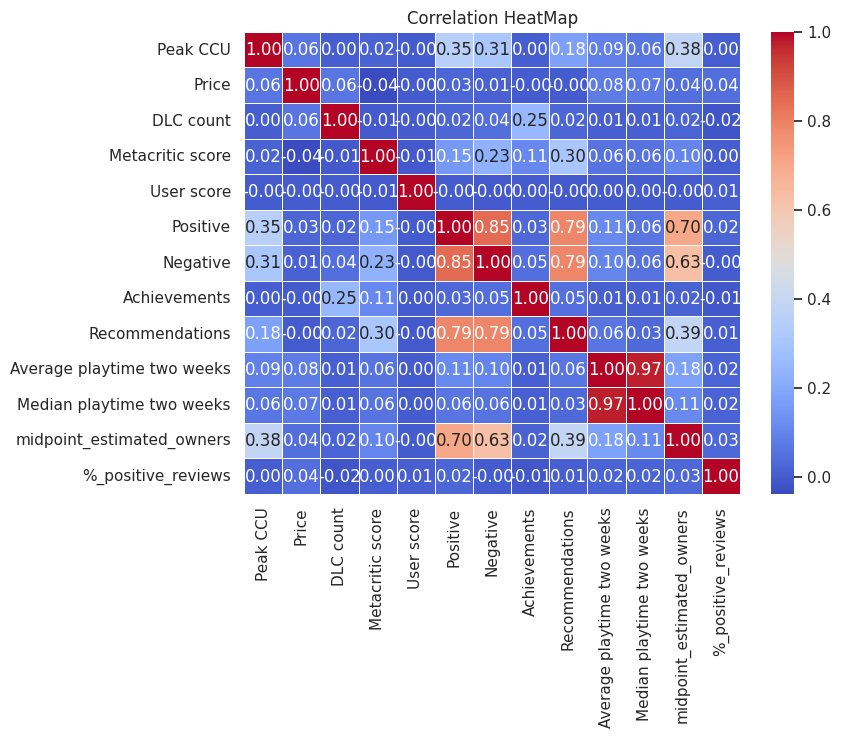

In [201]:
# Testing for Multicolinearity
steam_numerical = steam_encoded[['Peak CCU','Price','DLC count','Metacritic score',
                                 'User score','Positive','Negative','Achievements',
                                 'Recommendations','Average playtime two weeks',
                                 'Median playtime two weeks','midpoint_estimated_owners',
                                 '%_positive_reviews']]
correlation_matrix = steam_numerical.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation HeatMap')
plt.show()

This graphic shows that there is a strong relationship between positive reviews, negative reviews and recommendations. Since %_positive_reviews is just the percentage of positive reviews out of all reviews, it captures both columns. And recommendations is just how many people would recommend the game to someone else, which is also going to be highly tied to those who give it positive reviews. We can cut the positive and negative columns since the purpose of them is essentially captured by the %_positive and recommendations columns

We also need to drop one of average and median playtime. Which makes sense. One will get dropped, the other will be our response variate. Likely average.

But what about the midpoint_estimated_owners? What to do with that?

In [193]:
# Dropping Outliers
steam_encoded.iloc[75]

,75
Name,AmazeD 3D
Release date,"Jul 14, 2018"
Peak CCU,0
Price,0.0
DLC count,0
...,...
Tracked Motion Controller Support,0
VR Only,0
VR Support,0
VR Supported,0


In [ ]:
# Other Preprocessing That Could Be Done?


# get the list of columns for genres, categories, and ESRb ratings


NameError: name 'steam_drop' is not defined

In [148]:
steam_drop.columns.tolist()

['Name',
 'Release date',
 'Peak CCU',
 'Price',
 'DLC count',
 'Windows',
 'Mac',
 'Linux',
 'Metacritic score',
 'User score',
 'Positive',
 'Negative',
 'Achievements',
 'Recommendations',
 'Average playtime two weeks',
 'Median playtime two weeks',
 'Publishers',
 'Categories',
 'Genres',
 'midpoint_estimated_owners',
 'voice_acting',
 '%_positive_reviews',
 'genres_list']

We also want to limit our dataset to only those games that are most likely to have ESRB ratings, that way our API connection has a chance to pull the data within a reasonable time frame.

In [ ]:
# Creating a column that holds 0 if the game does not have language audio, 1 otherwise
def label_audio(row):
  if ['Full audio languages'].apply(len) > 2:
    return 1
  return 0

steam_drop['Full audio languages'] = steam_drop.apply(label_audio, axis=1)

df_noNan = steam_drop.dropna(subset=['Full audio languages'])
df_noNan.shape
print(steam_drop['Full audio languages'].apply(len) > 2)

AttributeError: 'list' object has no attribute 'apply'

# ESRB Dataset from API

In [ ]:
# preparing to pull from API
from requests import post
from pandas import json_normalize
import time

CLIENT_ID = "txzqvaseroq3axf5j2187prut4wvca"
BEARER_TOKEN = "6gyli4kexuu15qpunuy3bo9akdamw8"
INPUT_FILE = "games.csv"
OUTPUT_FILE = "/content/drive/MyDrive/CP322/esrb.csv"
REQUEST_DELAY = 0.3

headers = {
    "Client-ID": CLIENT_ID,
    "Authorization": f"Bearer {BEARER_TOKEN}"
}

In [ ]:
# Matching the Steam AppID from the import file to the API
def get_game_id(steam_id):
    query = f'fields game; where external_game_source = 1 & uid = "{steam_id}";'
    r = post("https://api.igdb.com/v4/external_games", headers=headers, data=query)
    r.raise_for_status()
    data = r.json()
    if not data:
        return None
    return data[0]["game"]

In [ ]:
# Getting the ESRB data from the API via the game ID
def get_esrb_rating(game_id):
    # Step 1: Fetch the game's age_ratings IDs from /games
    game_query = f"fields name, age_ratings; where id = {game_id};"
    r = post("https://api.igdb.com/v4/games", headers=headers, data=game_query)
    r.raise_for_status()
    data = r.json()
    if not data:
        return None, None, None

    game = data[0]
    name = game.get("name", "")
    rating_ids = game.get("age_ratings", [])

    if not rating_ids:
        print(f"  ⚠ {name} has no age_ratings assigned in IGDB.")
        return name, None, None

    # Step 2: Fetch full age_rating objects from /age_ratings
    rating_query = (
        "fields category, rating, content_descriptions.description;"
        f" where id = ({', '.join(map(str, rating_ids))});"
    )
    r2 = post("https://api.igdb.com/v4/age_ratings", headers=headers, data=rating_query)
    r2.raise_for_status()
    ratings = r2.json()

    print(f"  Fetched age_ratings for {name}: {ratings}")

    if not ratings:
        return name, None, None

    # Step 3: Try to find ESRB first (category == 1)
    for rating in ratings:
        if rating.get("category") == 1:
            esrb_rating = rating.get("rating")
            descriptions = [d["description"] for d in rating.get("content_descriptions", [])]
            return name, esrb_rating, ", ".join(descriptions)

    # Step 4: Fallback to first available rating if no ESRB
    r = ratings[0]
    fallback_rating = r.get("rating")
    fallback_descriptions = [d["description"] for d in r.get("content_descriptions", [])]
    print(f"  ⚠ {name} has no ESRB rating, falling back to another rating (category {r.get('category')})")
    return name, fallback_rating, ", ".join(fallback_descriptions)

In [ ]:
# Create test DataFrame
test = steam[:5]

In [ ]:
def main():
    #df = pd.read_csv(INPUT_FILE)
    results = []

    for i, row in test.iterrows():
        steam_id = str(row["AppID"])
        print(f"[{i+1}/{len(df)}] Fetching game for Steam ID {steam_id}...")

        igdb_id = get_game_id(steam_id)
        time.sleep(REQUEST_DELAY)

        if not igdb_id:
            print(f"  ❌ No IGDB match found for {steam_id}")
            results.append({
                "steam_appid": steam_id,
                "igdb_id": None,
                "name": None,
                "esrb_rating": None,
                "content_descriptors": None
            })
            continue

        name, esrb, descriptors = get_esrb_rating(igdb_id)
        time.sleep(REQUEST_DELAY)

        results.append({
            "steam_appid": steam_id,
            "igdb_id": igdb_id,
            "name": name,
            "esrb_rating": esrb,
            "content_descriptors": descriptors
        })
        print(f"  ✅ {name or 'Unknown'} — {esrb or 'No rating'}")

    pd.DataFrame(results).to_csv(OUTPUT_FILE, index=False)
    print(f"\n✅ Done! Saved results to {OUTPUT_FILE}")

if __name__ == "__main__":
    main()

[1/96] Fetching game for Steam ID 20200...
  Fetched age_ratings for Galactic Bowling: [{'id': 71406}]
  ⚠ Galactic Bowling has no ESRB rating, falling back to another rating (category None)
  ✅ Galactic Bowling — No rating
[2/96] Fetching game for Steam ID 655370...
  Fetched age_ratings for Train Bandit: [{'id': 85418}]
  ⚠ Train Bandit has no ESRB rating, falling back to another rating (category None)
  ✅ Train Bandit — No rating
[3/96] Fetching game for Steam ID 1732930...
  ❌ No IGDB match found for 1732930
[4/96] Fetching game for Steam ID 1355720...
  Fetched age_ratings for Henosis: [{'id': 43922}]
  ⚠ Henosis has no ESRB rating, falling back to another rating (category None)
  ✅ Henosis — No rating
[5/96] Fetching game for Steam ID 1139950...
  ⚠ Two Weeks in Painland has no age_ratings assigned in IGDB.
  ✅ Two Weeks in Painland — No rating
[6/96] Fetching game for Steam ID 1469160...
  ⚠ Wartune Reborn has no age_ratings assigned in IGDB.
  ✅ Wartune Reborn — No rating
[7/96

In [ ]:
import requests
import time
import difflib

# === Configuration ===
IGDB_GAMES_URL = "https://api.igdb.com/v4/games"
IGDB_AGE_RATINGS_URL = "https://api.igdb.com/v4/age_ratings"

IGDB_GAMES_URL = "https://api.igdb.com/v4/games"
IGDB_AGE_RATINGS_URL = "https://api.igdb.com/v4/age_ratings"

HEADERS = {
    "Client-ID": CLIENT_ID,
    "Authorization": f"Bearer {BEARER_TOKEN}",
    "Accept": "application/json"
}

FUZZY_THRESHOLD = 0.7

# Your list of game names
old = [
    "The Legend of Zelda: Breath of the Wild",
    "Super Mario Odyssey",
    "Galactic Bowling"
]

game_names = steam['Name'][:100]

def search_game(name, limit=10):
    """Search IGDB for a game by name. Returns candidate dicts."""
    body = f'search "{name}"; fields id,name; limit {limit};'
    resp = requests.post(IGDB_GAMES_URL, headers=HEADERS, data=body)
    resp.raise_for_status()
    return resp.json()

def get_age_ratings(age_rating_ids):
    """Given a list of age_rating IDs, fetch their details."""
    if not age_rating_ids:
        return []
    ids_str = ",".join(map(str, age_rating_ids))
    # Only fetch ESRB (organization=1)
    body = f'fields id,organization,rating_category,rating_content_descriptions,synopsis; where id = ({ids_str}) & organization = 1;'
    resp = requests.post(IGDB_AGE_RATINGS_URL, headers=HEADERS, data=body)
    resp.raise_for_status()
    return resp.json()

def fuzzy_best_match(target, candidates, key=lambda x: x["name"]):
    """Return the candidate with the best fuzzy match score."""
    best = None
    best_score = 0.0
    for c in candidates:
        score = difflib.SequenceMatcher(None, target.lower(), key(c).lower()).ratio()
        if score > best_score:
            best_score = score
            best = c
    return best, best_score

def safe_print(s):
    """Print Unicode safely to console."""
    print(str(s).encode('utf-8', errors='replace').decode('utf-8'))

def main():
    results = {}
    for name in game_names:
        safe_print(f"Searching for game: {name}")
        try:
            candidates = search_game(name, limit=20)
        except Exception as e:
            safe_print(f"  Error searching game '{name}': {e}")
            results[name] = {"error": str(e)}
            continue

        if not candidates:
            safe_print(f"  No IGDB results for '{name}'")
            results[name] = {"match": None, "score": None, "age_ratings": None}
            continue

        match, score = fuzzy_best_match(name, candidates)
        safe_print(f"  Best match: {match['name']} (ID={match['id']}) with score {score:.2f}")

        if score < FUZZY_THRESHOLD:
            safe_print(f"  Score below threshold ({FUZZY_THRESHOLD}); skipping age ratings.")
            results[name] = {"match": match, "score": score, "age_ratings": None}
            continue

        # fetch the game record in full (to get age_ratings field)
        body = f'fields age_ratings; where id = {match["id"]};'
        try:
            resp = requests.post(IGDB_GAMES_URL, headers=HEADERS, data=body)
            resp.raise_for_status()
            game_data = resp.json()
        except Exception as e:
            safe_print(f"  Error retrieving game details: {e}")
            results[name] = {"match": match, "score": score, "age_ratings": None, "error": str(e)}
            continue

        if not game_data or "age_ratings" not in game_data[0] or not game_data[0]["age_ratings"]:
            safe_print(f"  No age_ratings found for game ID {match['id']}")
            results[name] = {"match": match, "score": score, "age_ratings": []}
            continue

        age_ids = game_data[0]["age_ratings"]
        try:
            age_rating_details = get_age_ratings(age_ids)
        except Exception as e:
            safe_print(f"  Error retrieving age rating details: {e}")
            results[name] = {"match": match, "score": score, "age_ratings": None, "error": str(e)}
            continue

        # Keep only ESRB ratings (organization=1)
        esrb_ratings = [
            r for r in age_rating_details
              if r.get('organization') == 1 and 6 <= r.get('rating_category', 0) <= 12
        ]
        if not esrb_ratings:
            safe_print("  No ESRB ratings found for this game.")
        else:
            safe_print(f"  ESRB ratings: {esrb_ratings}")

        results[name] = {"match": match, "score": score, "age_ratings": esrb_ratings}

        # Respect IGDB rate limit
        time.sleep(0.3)

    # Print final results
    safe_print("\nFinal results:")
    for name, info in results.items():
        safe_print(f"- '{name}': {info}")

if __name__ == "__main__":
    main()

Searching for game: Galactic Bowling
  Best match: Galactic Bowling (ID=14922) with score 1.00
  No ESRB ratings found for this game.
Searching for game: Train Bandit
  Best match: Train Bandit (ID=68514) with score 1.00
  No ESRB ratings found for this game.
Searching for game: Jolt Project
  No IGDB results for 'Jolt Project'
Searching for game: Henosis™
  Best match: Henosis (ID=145712) with score 0.93
  No ESRB ratings found for this game.
Searching for game: Two Weeks in Painland
  Best match: Two Weeks in Painland (ID=126933) with score 1.00
  No age_ratings found for game ID 126933
Searching for game: Wartune Reborn
  Best match: Wartune Reborn (ID=160087) with score 1.00
  No age_ratings found for game ID 160087
Searching for game: TD Worlds
  Best match: TD Worlds (ID=168619) with score 1.00
  No age_ratings found for game ID 168619
Searching for game: Legend of Rome - The Wrath of Mars
  Best match: Legend of Rome: The Wrath of Mars (ID=199345) with score 0.96
  No age_rating

In [ ]:
response = post('https://api.igdb.com/v4/age_rating_content_descriptions_v2',
                **{'headers': {'Client-ID': CLIENT_ID, 'Authorization': f"Bearer {BEARER_TOKEN}"},
                   'data': 'fields checksum,created_at,description,description_type,organization,updated_at;'})


#print ("response: %s" % str(response.json()))
df = json_normalize(response.json())
print(df)

In [ ]:
response = post('https://api.igdb.com/v4/games',
                **{'headers': {'Client-ID': CLIENT_ID, 'Authorization': f"Bearer {BEARER_TOKEN}"},
                   'data': 'fields age_ratings,themes,name;'})


#print ("response: %s" % str(response.json()))
df = json_normalize(response.json())
print(df)

       id                                               name    themes  \
0  350392                                      Rival Species   [1, 18]   
1  287086                        Out of the Park Baseball 25       NaN   
2  119985  Welcome to... Chichester 2: Part II - No Regre...  [27, 31]   
3  339266                                    Power Guy World       NaN   
4  204348                                      What the Bat?      [27]   
5   63844                                      Ace wo Nerae!       [1]   
6  371149                                           The Deal       NaN   
7  330684                      Nightmare Kart: The Old Karts       [1]   
8  278175                                100 Kills Challenge       [1]   
9  233359                                Montezuma's Revenge       [1]   

  age_ratings  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4    [105017]  
5         NaN  
6         NaN  
7         NaN  
8         NaN  
9         NaN  


In [ ]:
response = post('https://api.igdb.com/v4/age_rating_content_descriptions_v2',
                **{'headers': {'Client-ID': CLIENT_ID, 'Authorization': f"Bearer {BEARER_TOKEN}"},
                   'data': 'fields description,organization; limit 100;'})


#print ("response: %s" % str(response.json()))
df = json_normalize(response.json())
print(df)

    id        description  organization
0   15     Partial Nudity             1
1    4     Blood and Gore             1
2    7        Crude Humor             1
3   18      Sexual Themes             1
4    8     Drug Reference             1
..  ..                ...           ...
91  58  In-Game Purchases             2
92  57    Online Gameplay             2
93  60     Sexual Content             3
94  61           Violence             3
95   6     Comic Mischief             1

[96 rows x 3 columns]


In [ ]:
20200
655370
1732930